<a href="https://colab.research.google.com/github/manashpratim/NIPS-Analysis/blob/master/Text_Summarizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Seq2Seq** LSTM Text Summarizer

In [1]:
!wget --no-check-certificate \
      "https://storage.googleapis.com/kaggle-datasets/491/9097/papers.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1561714834&Signature=ZzX3AmnGPVRf8wo3m97I%2B%2Fs%2FjJ3umoNMjPcjCxscCuhL9K65qY0XZj%2FX7nJbSZXJ8FODdxvWwqeD0%2Bqpc0Zmfm85QPnKVIQovo%2BdXuRIkgytxAKOn6f%2BDdbDjw%2FELttFejPQF1WrVgAKXe3L0gE7lTaC05pZ8vR3ysQ%2BU2U6VjiUHUM0xlO63eIohURdU5pCiyH1IHt%2BpI2kMvxe9ivv7a0%2BNNYeM7JQvD8oIYR6Q10FTWqphyKdIoVloQGhpVw2QhDIo5Gcd0Exqal6R8RjbNRe84fQcayogU2wHSPi0CGM1lD2fQBqww3bK3%2Bd2adC6%2B4BKx8sObF3X9%2Fie5gn9A%3D%3D"\
      -O "/tmp/nips.zip"

--2019-06-26 15:46:56--  https://storage.googleapis.com/kaggle-datasets/491/9097/papers.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1561714834&Signature=ZzX3AmnGPVRf8wo3m97I%2B%2Fs%2FjJ3umoNMjPcjCxscCuhL9K65qY0XZj%2FX7nJbSZXJ8FODdxvWwqeD0%2Bqpc0Zmfm85QPnKVIQovo%2BdXuRIkgytxAKOn6f%2BDdbDjw%2FELttFejPQF1WrVgAKXe3L0gE7lTaC05pZ8vR3ysQ%2BU2U6VjiUHUM0xlO63eIohURdU5pCiyH1IHt%2BpI2kMvxe9ivv7a0%2BNNYeM7JQvD8oIYR6Q10FTWqphyKdIoVloQGhpVw2QhDIo5Gcd0Exqal6R8RjbNRe84fQcayogU2wHSPi0CGM1lD2fQBqww3bK3%2Bd2adC6%2B4BKx8sObF3X9%2Fie5gn9A%3D%3D
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.25.208, 2404:6800:4004:81b::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.25.208|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73128610 (70M) [application/zip]
Saving to: ‘/tmp/nips.zip’

/tmp/nips.zip       100%[===================>]  69.74M   171MB/s    in 0.4s    

2019-06-26 15:46:56 (171 MB/s) - ‘/tmp/ni

In [0]:
# Unzipping the downloaded dataset
import os
import zipfile

local_zip='/tmp/nips.zip'
zip_ref=zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp/nips')
zip_ref.close()

In [0]:
import pandas as pd
df=pd.read_csv('/tmp/nips/papers.csv')

In [0]:
nips=[]
for i in range(len(df)):
  paper=[]
  paper.append(df['title'][i])
  paper.append(df['paper_text'][i])
  nips.append(paper)
  

In [0]:
for i in range(len(nips)):
  abstract=nips[i][1].find('ABSTRACT')
  references=nips[i][1].find('REFERENCES')
  nips[i][1]=nips[i][1][abstract:references]

In [6]:
import nltk
from nltk import word_tokenize
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('punkt')
stop_words = set(stopwords.words('english'))
def mystopwords(text):
    return ' '.join([w for w in word_tokenize(text) if not w in stop_words])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [0]:
import re
def clean_text(string):
  clean=re.sub('[\n]',' ',string)
  clean=re.sub('[^a-zA-Z]',' ',clean)
  clean=mystopwords(clean)
  return clean

In [0]:
for i in range(len(nips)):
  nips[i][0]=clean_text(nips[i][0])
  nips[i][1]=clean_text(nips[i][1])

In [0]:
sentences=[]
labels=[]
for i in range(len(nips)):
  sentences.append(nips[i][1])
  labels.append(nips[i][0])

In [0]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers

embedding_dim = 100
max_length = 1000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=len(nips)
test_portion=.1


tokenizer = Tokenizer()
tokenizer.fit_on_texts(sentences)

text_word_index = tokenizer.word_index
text_vocab_size=len(text_word_index)

text_sequences = tokenizer.texts_to_sequences(sentences)
text_padded = pad_sequences(text_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)


tokenizer.fit_on_texts(labels)

label_word_index = tokenizer.word_index
label_vocab_size=len(label_word_index)

label_sequences = tokenizer.texts_to_sequences(labels)
label_padded = pad_sequences(label_sequences, maxlen=15, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = text_padded[0:split]
training_sequences = text_padded[split:training_size]
test_labels = label_padded[0:split]
training_labels = label_padded[split:training_size]

In [11]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {}
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

vocab_zize=14999
        
        
text_embeddings_matrix = np.zeros((text_vocab_size+1, embedding_dim))
for word, i in text_word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        text_embeddings_matrix[i] = embedding_vector
        
        
label_embeddings_matrix = np.zeros((label_vocab_size+1, embedding_dim))
for word, i in label_word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        label_embeddings_matrix[i] = embedding_vector

--2019-06-26 15:49:15--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.31.176, 2404:6800:4004:80b::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.31.176|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  65.7MB/s    in 5.0s    

2019-06-26 15:49:20 (65.7 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [0]:
label_embeddings_matrix=label_embeddings_matrix[:15000]
text_embeddings_matrix=text_embeddings_matrix[:15000]

In [16]:
print(label_embeddings_matrix.shape)
print(text_embeddings_matrix.shape)

(15000, 100)
(15000, 100)


In [13]:
import keras
from keras import initializers
from keras.optimizers import RMSprop
from keras.models import Sequential,Model
from keras.layers import Dense,LSTM,Dropout,Input,Activation,Add,concatenate, Embedding, RepeatVector
from keras.layers.advanced_activations import LeakyReLU,PReLU
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from keras.optimizers import Adam

Using TensorFlow backend.
W0626 15:49:35.364032 140347136403328 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:153: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [0]:
encoder_embedding_layer = Embedding(input_dim = 15000, 
                                    output_dim = 100,
                                    input_length = max_length,
                                    weights = [text_embeddings_matrix],
                                    trainable = False)
decoder_embedding_layer = Embedding(input_dim = 15000, 
                                    output_dim = 100,
                                    input_length = 15,
                                    weights = [label_embeddings_matrix],
                                    trainable = False)

In [0]:
#MAX_LEN = 100
VOCAB_SIZE =15000
EMBEDDING_DIM = 100
HIDDEN_UNITS = 64
#VOCAB_SIZE = VOCAB_SIZE 

LEARNING_RATE = 0.002
BATCH_SIZE = 32
EPOCHS = 3

In [0]:
encoder_inputs = Input(shape=(1000,))
encoder_embedding = encoder_embedding_layer(encoder_inputs)
encoder_LSTM = LSTM(HIDDEN_UNITS, return_state=True)
encoder_LSTM_R = LSTM(HIDDEN_UNITS, return_state=True, go_backwards=True)
encoder_LSTM_S = LSTM(HIDDEN_UNITS, return_state=True, go_backwards=True)
encoder_outputs_R, state_h_R, state_c_R = encoder_LSTM_R(encoder_embedding)
encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)
#encoder_outputs_S, state_h_S, state_c_S = encoder_LSTM_S(encoder_embedding)

final_h = Add()([state_h, state_h_R])
final_c = Add()([state_c, state_c_R])
encoder_states = [final_h, final_c]

"""
decoder
"""
decoder_inputs = Input(shape=(15,))
decoder_embedding = decoder_embedding_layer(decoder_inputs)
decoder_LSTM = LSTM(HIDDEN_UNITS, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=encoder_states) 
#decoder_dense_1 = Dense(VOCAB_SIZE//2, activation='relu')

decoder_dense_2 = Dense(VOCAB_SIZE, activation='relu')
#decoder_outputs = decoder_dense_1(decoder_outputs)
decoder_outputs = decoder_dense_2(decoder_outputs)
model= Model(inputs=[encoder_inputs,decoder_inputs], outputs=decoder_outputs)

In [18]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1000, 100)    1500000     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 15)           0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 64), (None,  42240       embedding_1[1][0]                
__________________________________________________________________________________________________
lstm_2 (LS

In [0]:
rmsprop = RMSprop(lr=0.01, clipnorm=1.)
#model.compile(loss='mse', optimizer='adam', metrics=["accuracy"])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=["accuracy"])


In [0]:
import numpy as np
num_samples = len(label_padded)
#decoder_output_data = np.zeros((num_samples, MAX_LEN, VOCAB_SIZE))
decoder_output_data = np.memmap('my_array.mmap',dtype='int32', mode='w+', shape=(num_samples, 15, VOCAB_SIZE))

In [0]:
for i, seqs in enumerate(label_padded):
    for j, seq in enumerate(seqs):
        if j > 0 and seq<=15000:
            decoder_output_data[i][j][seq] = 1
             #out = np.memmap('my_array.mmap', 'w+', shape=(200001, 3504), dtype=np.int64)

In [0]:
target_test = decoder_output_data[:split]
target_train = decoder_output_data[split:]

In [26]:
history = model.fit([training_sequences, training_labels], 
                     target_train, 
                     epochs=30, 
                     batch_size=500,
                     validation_data=([test_sequences, test_labels], target_test))

Train on 6517 samples, validate on 724 samples
Epoch 1/30
6517/6517 [==============================] - 32s 5ms/step - loss: 5.7408 - acc: 0.4913 - val_loss: 3.8450 - val_acc: 0.6099
Epoch 2/30
6517/6517 [==============================] - 45s 7ms/step - loss: 3.4126 - acc: 0.6187 - val_loss: 3.4642 - val_acc: 0.6167
Epoch 3/30
6517/6517 [==============================] - 43s 7ms/step - loss: 3.1144 - acc: 0.6272 - val_loss: 3.2560 - val_acc: 0.6252
Epoch 4/30
6517/6517 [==============================] - 31s 5ms/step - loss: 2.9222 - acc: 0.6378 - val_loss: 3.1280 - val_acc: 0.6384
Epoch 5/30
6517/6517 [==============================] - 38s 6ms/step - loss: 2.7774 - acc: 0.6776 - val_loss: 2.9295 - val_acc: 0.7218
Epoch 6/30
6517/6517 [==============================] - 32s 5ms/step - loss: 2.5705 - acc: 0.7439 - val_loss: 2.7406 - val_acc: 0.7371
Epoch 7/30
6517/6517 [==============================] - 31s 5ms/step - loss: 2.3500 - acc: 0.7604 - val_loss: 1.9924 - val_acc: 0.7618
Epoch 8/

<Figure size 432x288 with 0 Axes>

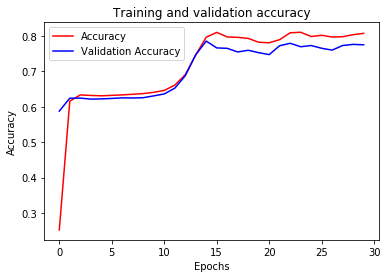

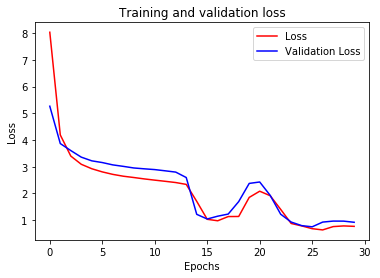

<Figure size 432x288 with 0 Axes>

In [52]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

